# Projet Data

In [2]:
#!pip install pmdarima

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Charger le dataset
df = pd.read_csv('urgences_data.csv', encoding='latin1')

# Aperçu des premières lignes
df.head()

,date_heure_arrivee,id_passage,mois,heure,jour_semaine,annee,alerte_epidemique,temperature_max,indicateur_greve,evenement_externe,...,devenir_patient,temps_passage_total,date_heure_arrivee_encoded,alerte_epidemique_encoded,batiment_accueil_encoded,site_accueil_encoded,filiere_pathologie_encoded,mode_transport_encoded,besoin_imagerie_encoded,devenir_patient_encoded
0,01/11/2020 00:05,1000001,11,0,6,2020,Bronchiolite,15.983798,0,0,...,Retour Domicile,341,13518,1,1,0,4,0,1,1
1,01/11/2020 00:05,1000002,11,0,6,2020,Bronchiolite,15.983798,0,0,...,Retour Domicile,335,13518,1,1,0,6,0,1,1
2,01/11/2020 00:47,1000003,11,0,6,2020,Bronchiolite,12.006751,0,0,...,Transfert,254,13519,1,1,0,7,3,0,2
3,01/11/2020 00:54,1000004,11,0,6,2020,Bronchiolite,12.834808,0,0,...,Retour Domicile,298,13520,1,1,0,2,1,1,1
4,01/11/2020 01:24,1000005,11,1,6,2020,Bronchiolite,14.335864,0,0,...,Retour Domicile,228,13521,1,1,0,9,3,0,1


## Analyse exploratoire des données

In [4]:
# Dimensions, types de colonnes et mémoire
print(df.info())

# Statistiques descriptives (moyenne, quartiles, etc.)
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570282 entries, 0 to 570281
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   date_heure_arrivee          570282 non-null  object 
 1   id_passage                  570282 non-null  int64  
 2   mois                        570282 non-null  int64  
 3   heure                       570282 non-null  int64  
 4   jour_semaine                570282 non-null  int64  
 5   annee                       570282 non-null  int64  
 6   alerte_epidemique           570282 non-null  object 
 7   temperature_max             570282 non-null  float64
 8   indicateur_greve            570282 non-null  int64  
 9   evenement_externe           570282 non-null  int64  
 10  niveau_pollution            570282 non-null  int64  
 11  batiment_accueil            570282 non-null  object 
 12  site_accueil                570282 non-null  object 
 13  age_patient   

In [5]:
# Vérifier le nombre de valeurs nulles par colonne
print(df.isnull().sum())

# Supprimer les doublons
df = df.drop_duplicates()

date_heure_arrivee            0
id_passage                    0
mois                          0
heure                         0
jour_semaine                  0
annee                         0
alerte_epidemique             0
temperature_max               0
indicateur_greve              0
evenement_externe             0
niveau_pollution              0
batiment_accueil              0
site_accueil                  0
age_patient                   0
filiere_pathologie            0
score_IAO                     0
mode_transport                0
effectif_soignant_present     0
dispo_lits_aval               0
besoin_imagerie               0
consommation_O2               0
kit_traumatologie             0
solutes_hydratation           0
devenir_patient               0
temps_passage_total           0
date_heure_arrivee_encoded    0
alerte_epidemique_encoded     0
batiment_accueil_encoded      0
site_accueil_encoded          0
filiere_pathologie_encoded    0
mode_transport_encoded        0
besoin_i

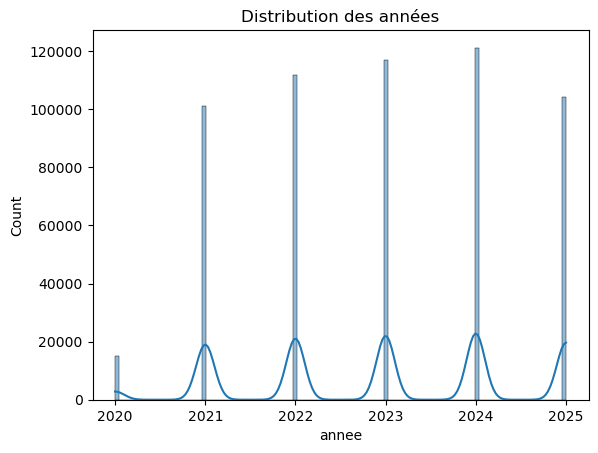

In [6]:
# Distribution d'une variable numérique
sns.histplot(df['annee'], kde=True)
plt.title('Distribution des années')
plt.show()

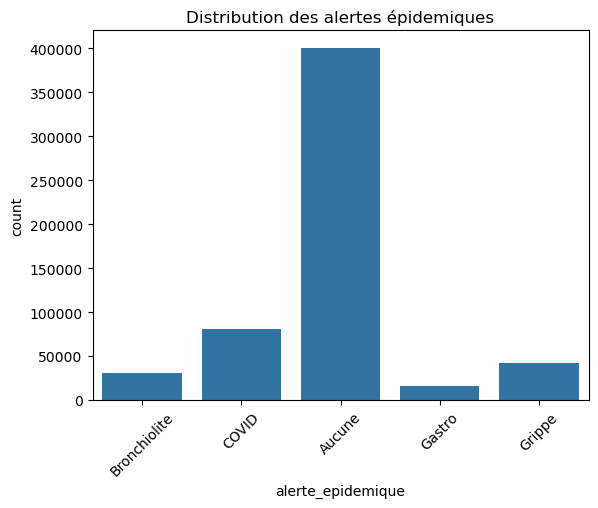

In [7]:
# Fréquence d'une variable catégorielle
sns.countplot(x='alerte_epidemique', data=df)
plt.xticks(rotation=45)
plt.title('Distribution des alertes épidemiques')
plt.show()

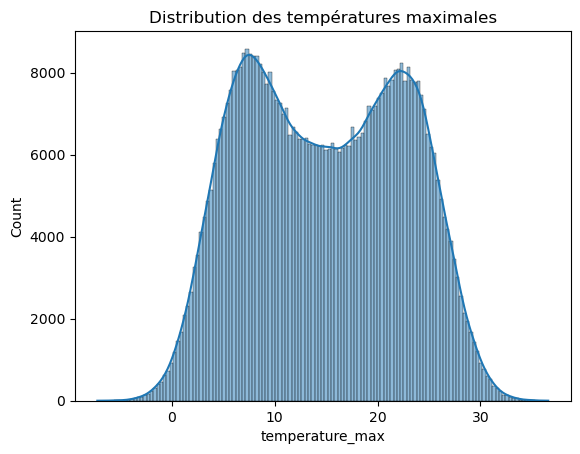

In [8]:
# Distribution d'une variable numérique
sns.histplot(df['temperature_max'], kde=True)
plt.title('Distribution des températures maximales')
plt.show()

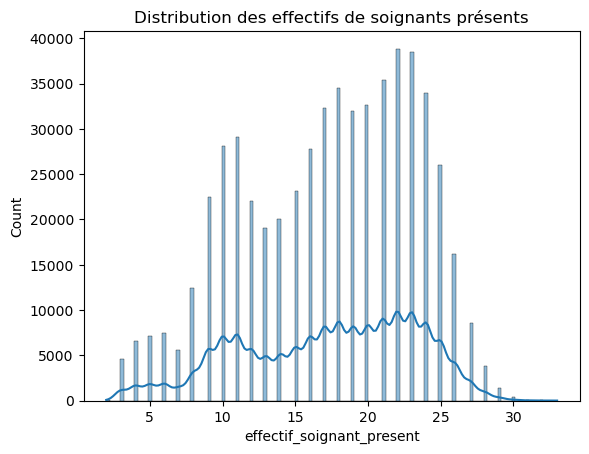

In [9]:
# Distribution d'une variable numérique
sns.histplot(df['effectif_soignant_present'], kde=True)
plt.title('Distribution des effectifs de soignants présents')
plt.show()

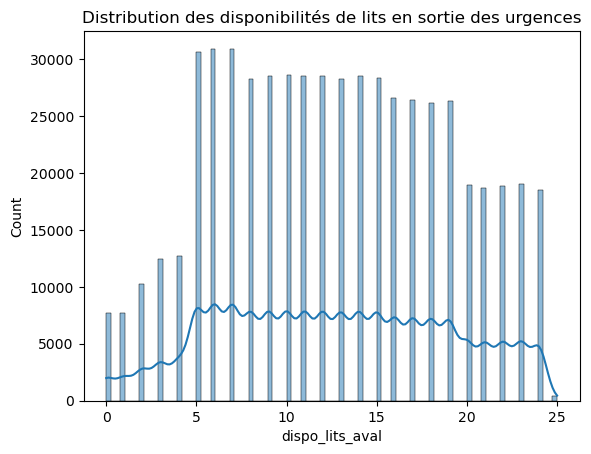

In [10]:
# Distribution d'une variable numérique
sns.histplot(df['dispo_lits_aval'], kde=True)
plt.title('Distribution des disponibilités de lits en sortie des urgences')
plt.show()

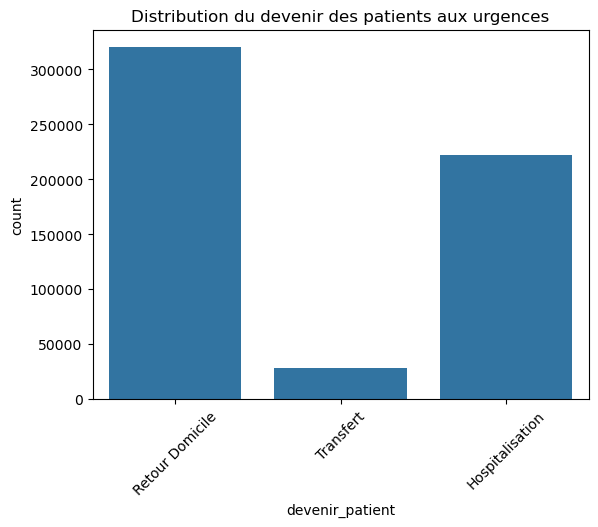

In [11]:
# Fréquence d'une variable catégorielle
sns.countplot(x='devenir_patient', data=df)
plt.xticks(rotation=45)
plt.title('Distribution du devenir des patients aux urgences')
plt.show()

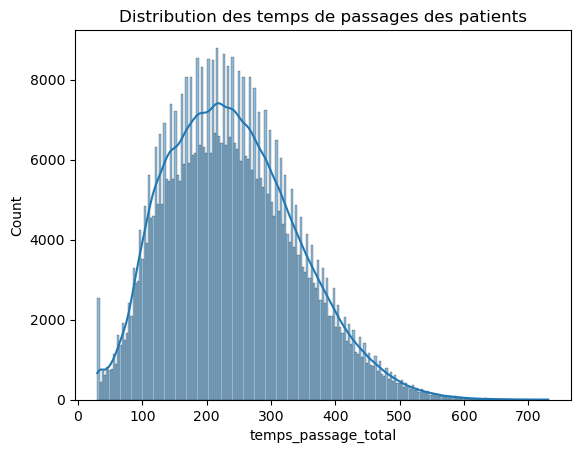

In [12]:
# Distribution d'une variable numérique
sns.histplot(df['temps_passage_total'], kde=True)
plt.title('Distribution des temps de passages des patients')
plt.show()

## Feature Engineering

In [14]:
# Conversion de la colonne en format datetime
df['date_heure_arrivee'] = pd.to_datetime(df['date_heure_arrivee'], format='%d/%m/%Y %H:%M')

# Fix the timestamp logic
# - Day part from original date
# - Hour part from 'heure' column
# - Minutes always '00'
df['date_hourly'] = df['date_heure_arrivee'].dt.normalize() + pd.to_timedelta(df['heure'], unit='h')

In [15]:
# Estimer la date et l'heure de sortie
df["date_heure_sortie_estimee"] = (
    df["date_heure_arrivee"] + pd.to_timedelta(df["temps_passage_total"], unit="m")
)

# Create two dataframes: one for arrivals, one for exits
arrivals = pd.DataFrame({'time': df['date_heure_arrivee'], 'change': 1})
exits = pd.DataFrame({'time': df['date_heure_sortie_estimee'], 'change': -1})

# Combine and sort them by time
events = pd.concat([arrivals, exits]).sort_values(by='time')

# Calculate the running total (cumulative sum)
events['occupancy'] = events['change'].cumsum()

# Merge back to the original dataframe to get the count at arrival time
# 'merge_asof' is perfect here: it finds the occupancy state at the exact arrival moment
df = df.sort_values('date_heure_arrivee')
df = pd.merge_asof(
    df, 
    events[['time', 'occupancy']], 
    left_on='date_heure_arrivee', 
    right_on='time', 
    direction='backward'
)

# Final calculation
CAPACITE_LITS = 30
df["nb_patients_en_cours"] = df['occupancy']
df["occup_lits_estimee"] = df["nb_patients_en_cours"] / CAPACITE_LITS

df.head()

,date_heure_arrivee,id_passage,mois,heure,jour_semaine,annee,alerte_epidemique,temperature_max,indicateur_greve,evenement_externe,...,filiere_pathologie_encoded,mode_transport_encoded,besoin_imagerie_encoded,devenir_patient_encoded,date_hourly,date_heure_sortie_estimee,time,occupancy,nb_patients_en_cours,occup_lits_estimee
0,2020-11-01 00:05:00,1000001,11,0,6,2020,Bronchiolite,15.983798,0,0,...,4,0,1,1,2020-11-01 00:00:00,2020-11-01 05:46:00,2020-11-01 00:05:00,2,2,0.066667
1,2020-11-01 00:05:00,1000002,11,0,6,2020,Bronchiolite,15.983798,0,0,...,6,0,1,1,2020-11-01 00:00:00,2020-11-01 05:40:00,2020-11-01 00:05:00,2,2,0.066667
2,2020-11-01 00:47:00,1000003,11,0,6,2020,Bronchiolite,12.006751,0,0,...,7,3,0,2,2020-11-01 00:00:00,2020-11-01 05:01:00,2020-11-01 00:47:00,3,3,0.100000
3,2020-11-01 00:54:00,1000004,11,0,6,2020,Bronchiolite,12.834808,0,0,...,2,1,1,1,2020-11-01 00:00:00,2020-11-01 05:52:00,2020-11-01 00:54:00,4,4,0.133333
4,2020-11-01 01:24:00,1000005,11,1,6,2020,Bronchiolite,14.335864,0,0,...,9,3,0,1,2020-11-01 01:00:00,2020-11-01 05:12:00,2020-11-01 01:24:00,5,5,0.166667


In [16]:
# Set the index
df = df.set_index('date_hourly')

# Use resample('h') to make each row an HOUR
# We use .agg to calculate the Mean (duration) and the Count (patients) simultaneously
df_hourly = df.resample('h').agg({
    'id_passage': 'count',          # The number of patients for that hour
    'temps_passage_total': 'mean',  # The average duration for that hour
    'mois': 'mean',
    'heure': 'mean',
    'jour_semaine': 'mean',
    'annee': 'mean',
    'temperature_max': 'max',
    'indicateur_greve': 'max',
    'evenement_externe': 'max',
    'niveau_pollution': 'max',
    'age_patient': 'mean',
    'score_IAO': 'max',
    'effectif_soignant_present': 'mean',
    'dispo_lits_aval': 'min',
    'consommation_O2': 'min',
    'kit_traumatologie': 'min',
    'solutes_hydratation': 'min',
    'alerte_epidemique_encoded': 'mean',
    'batiment_accueil_encoded': 'mean',
    'filiere_pathologie_encoded': 'mean',
    'mode_transport_encoded': 'mean',
    'besoin_imagerie_encoded': 'mean',
    'devenir_patient_encoded': 'mean',
    'nb_patients_en_cours': 'max',
    'occup_lits_estimee': 'max'
}).rename(columns={
    'temps_passage_total': 'temps_passage_moyen',
    'id_passage': 'patient_count'
})


# Handle NaNs (required for SARIMAX and before casting to int)
df_hourly['patient_count'] = df_hourly['patient_count'].fillna(0)
# Forward fill to handle hours with no patients
df_hourly = df_hourly.ffill().bfill()

# Identify all columns that end with '_encoded'
encoded_cols = [col for col in df_hourly.columns if col.endswith('_encoded')]
# Apply rounding and integer casting to all of them
df_hourly[encoded_cols] = df_hourly[encoded_cols].round().astype(int)

df_hourly.head()

,patient_count,temps_passage_moyen,mois,heure,jour_semaine,annee,temperature_max,indicateur_greve,evenement_externe,niveau_pollution,...,kit_traumatologie,solutes_hydratation,alerte_epidemique_encoded,batiment_accueil_encoded,filiere_pathologie_encoded,mode_transport_encoded,besoin_imagerie_encoded,devenir_patient_encoded,nb_patients_en_cours,occup_lits_estimee
date_hourly,,,,,,,,,,,,,,,,,,,,,
2020-11-01 00:00:00,4,307.000000,11.0,0.0,6.0,2020.0,15.983798,0.0,0.0,5.0,...,0.0,0.0,1,1,5,1,1,1,4.0,0.133333
2020-11-01 01:00:00,3,263.666667,11.0,1.0,6.0,2020.0,16.753026,0.0,0.0,7.0,...,0.0,0.0,1,1,9,2,1,1,7.0,0.233333
2020-11-01 02:00:00,6,201.000000,11.0,2.0,6.0,2020.0,21.034677,0.0,0.0,5.0,...,0.0,0.0,1,2,5,2,0,1,13.0,0.433333
2020-11-01 03:00:00,3,269.333333,11.0,3.0,6.0,2020.0,16.628042,0.0,0.0,4.0,...,0.0,0.0,1,1,7,2,1,1,16.0,0.533333
2020-11-01 04:00:00,4,187.250000,11.0,4.0,6.0,2020.0,17.000000,0.0,0.0,9.0,...,0.0,0.0,2,2,7,2,1,0,18.0,0.600000


In [17]:
# Calcul du point de scission
split_index = int(len(df_hourly) * 0.8)

# Découpage chronologique
train = df_hourly.iloc[:split_index]
test = df_hourly.iloc[split_index:]

print(f"Total créneaux horaires : {len(df_hourly)}")
print(f"Train set (80%)   : {len(train)}")
print(f"Test set (20%)    : {len(test)}")

Total créneaux horaires : 43824
Train set (80%)   : 35059
Test set (20%)    : 8765


## Modèle de prédiction SARIMAX

### Test d'Augmented Dickey-Fuller (ADF)

« Le test augmenté de Dickey-Fuller ou test ADF est un test statistique qui vise à savoir si une série temporelle est stationnaire c'est-à-dire si ses propriétés statistiques (espérance, variance, auto-corrélation) varient ou pas dans le temps. » - Wikipédia

In [20]:
def run_adf_test(series):
    print(f"Résultats du test de Dickey-Fuller pour la série : {series.name}")
    result = adfuller(series)
    
    labels = [
        'Statistique de test', 
        'p-value', 
        'Nombre de retards utilisés', 
        'Nombre d\'observations'
    ]
    
    for value, label in zip(result, labels):
        print(f'{label} : {value}')

    for key, value in result[4].items():
        print(f'Valeur critique ({key}) : {value}')

    if result[1] <= 0.05:
        print("\nConclusion : On rejette l'hypothèse nulle (H0). La série est stationnaire.")
    else:
        print("\nConclusion : On ne peut pas rejeter l'hypothèse nulle (H0). La série n'est pas stationnaire.")

# Tester la stationnarité du temps de passage moyen
run_adf_test(df_hourly['temps_passage_moyen'])

Résultats du test de Dickey-Fuller pour la série : temps_passage_moyen
Statistique de test : -20.459032765861895
p-value : 0.0
Nombre de retards utilisés : 55
Nombre d'observations : 43768
Valeur critique (1%) : -3.4304994170070295
Valeur critique (5%) : -2.861606039041269
Valeur critique (10%) : -2.5668051504336344

Conclusion : On rejette l'hypothèse nulle (H0). La série est stationnaire.


### Définition de la variable cible et des valeurs exogènes

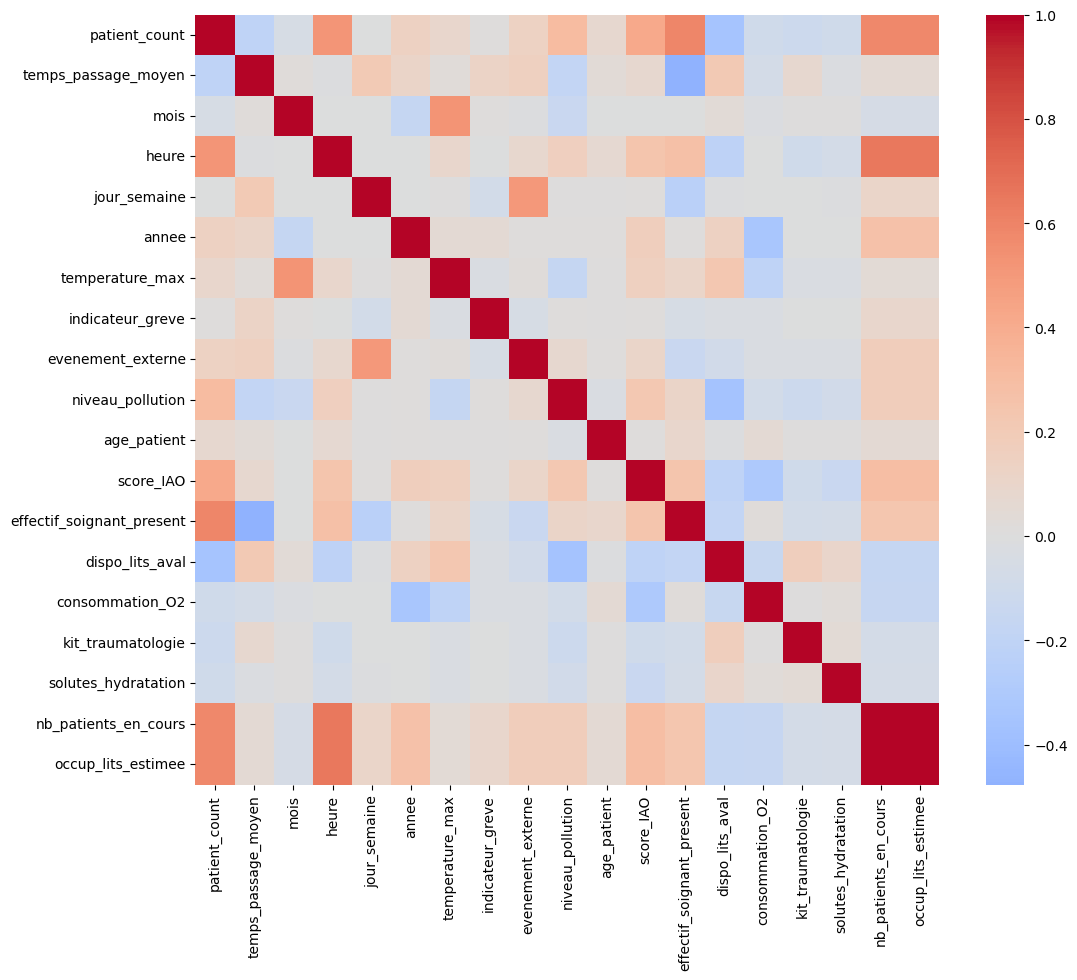

In [22]:
num_cols = df_hourly.select_dtypes(include=["int64", "float64"]).columns
plt.figure(figsize=(12, 10))
sns.heatmap(df_hourly[num_cols].corr(), cmap="coolwarm", center=0)
plt.show()

In [23]:
# Définition de la variable cible et des variables explicatives
y_train = train['temps_passage_moyen']
exog_train = train[['patient_count', 'jour_semaine', 'effectif_soignant_present', 'dispo_lits_aval']]

y_test = test['temps_passage_moyen']
exog_test = test[['patient_count', 'jour_semaine', 'effectif_soignant_present', 'dispo_lits_aval']]

**Corrélation de Spearman (Non-linéaire)**

Plus robuste que la corrélation classique, elle permet de voir quelles variables exogènes bougent en synchronisation avec notre variable cible.

In [25]:
correlations = exog_train.corrwith(y_train, method='spearman').sort_values(ascending=False)
print(correlations)

jour_semaine                 0.225905
dispo_lits_aval              0.210291
patient_count               -0.192144
effectif_soignant_present   -0.483090
dtype: float64


**Tests de Causalité de Granger**

Ce test permet de vérifier si les valeurs passées d'une variable exogène aident statistiquement à prédire les valeurs futures de notre variable cible.

In [27]:
# Test pour une variable spécifique
data_test = pd.concat([y_train, exog_train['effectif_soignant_present']], axis=1)
grangercausalitytests(data_test, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4550.1686, p=0.0000  , df_denom=35055, df_num=1
ssr based chi2 test:   chi2=4550.5580, p=0.0000  , df=1
likelihood ratio test: chi2=4278.5265, p=0.0000  , df=1
parameter F test:         F=4550.1686, p=0.0000  , df_denom=35055, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1613.7739, p=0.0000  , df_denom=35052, df_num=2
ssr based chi2 test:   chi2=3228.0081, p=0.0000  , df=2
likelihood ratio test: chi2=3087.9285, p=0.0000  , df=2
parameter F test:         F=1613.7739, p=0.0000  , df_denom=35052, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1289.3372, p=0.0000  , df_denom=35049, df_num=3
ssr based chi2 test:   chi2=3868.7841, p=0.0000  , df=3
likelihood ratio test: chi2=3669.8159, p=0.0000  , df=3
parameter F test:         F=1289.3372, p=0.0000  , df_denom=35049, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:       

{1: ({'ssr_ftest': (4550.168640626926, 0.0, 35055.0, 1),
   'ssr_chi2test': (4550.558043163565, 0.0, 1),
   'lrtest': (4278.52650064067, 0.0, 1),
   'params_ftest': (4550.168640627121, 0.0, 35055.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1613.7738619841875, 0.0, 35052.0, 2),
   'ssr_chi2test': (3228.0081182003687, 0.0, 2),
   'lrtest': (3087.9284786974313, 0.0, 2),
   'params_ftest': (1613.7738619842098, 0.0, 35052.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1289.337188732394, 0.0, 35049.0, 3),
   'ssr_chi2test': (3868.7840869813235, 0.0, 3),
   'lrtest': (3669.81590408762, 0.0, 3),
   'params_ftest': (1289.337188732392, 0.0, 35049.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])]),
 4: ({'ssr_ftest': (1041.790589398914, 0.0, 35046.0, 4),
   'ssr_chi2test': (4168.232507148197, 0.0, 4),
   'lrtest': (3938.4636241979897, 0.0, 4),
   'para

In [28]:
data_test = pd.concat([y_train, exog_train['jour_semaine']], axis=1)
grangercausalitytests(data_test, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=591.4322, p=0.0000  , df_denom=35055, df_num=1
ssr based chi2 test:   chi2=591.4828, p=0.0000  , df=1
likelihood ratio test: chi2=586.5486, p=0.0000  , df=1
parameter F test:         F=591.4322, p=0.0000  , df_denom=35055, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=195.2044, p=0.0000  , df_denom=35052, df_num=2
ssr based chi2 test:   chi2=390.4645, p=0.0000  , df=2
likelihood ratio test: chi2=388.3060, p=0.0000  , df=2
parameter F test:         F=195.2044, p=0.0000  , df_denom=35052, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=103.1470, p=0.0000  , df_denom=35049, df_num=3
ssr based chi2 test:   chi2=309.5028, p=0.0000  , df=3
likelihood ratio test: chi2=308.1445, p=0.0000  , df=3
parameter F test:         F=103.1470, p=0.0000  , df_denom=35049, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=70.8493 

{1: ({'ssr_ftest': (591.4321704871236, 1.453373938616266e-129, 35055.0, 1),
   'ssr_chi2test': (591.4827851358601, 1.192292947453608e-130, 1),
   'lrtest': (586.548590573424, 1.4113757218833628e-129, 1),
   'params_ftest': (591.4321704871348, 1.4533739386105656e-129, 35055.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (195.20441138932537, 4.925415895743018e-85, 35052.0, 2),
   'ssr_chi2test': (390.4645127282654, 1.628202328658897e-85, 2),
   'lrtest': (388.3060304716346, 4.790897046232075e-85, 2),
   'params_ftest': (195.20441138933433, 4.925415895694582e-85, 35052.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (103.14699081250261, 1.7675065766964255e-66, 35049.0, 3),
   'ssr_chi2test': (309.50277410965435, 8.729619859098054e-67, 3),
   'lrtest': (308.14449228928424, 1.7178828331759986e-66, 3),
   'params_ftest': (103.14699081250619, 1.7675065766860267e-66, 35049.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0.

In [29]:
data_test = pd.concat([y_train, exog_train['dispo_lits_aval']], axis=1)
grangercausalitytests(data_test, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=195.9529, p=0.0000  , df_denom=35055, df_num=1
ssr based chi2 test:   chi2=195.9696, p=0.0000  , df=1
likelihood ratio test: chi2=195.4239, p=0.0000  , df=1
parameter F test:         F=195.9529, p=0.0000  , df_denom=35055, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=64.6821 , p=0.0000  , df_denom=35052, df_num=2
ssr based chi2 test:   chi2=129.3826, p=0.0000  , df=2
likelihood ratio test: chi2=129.1444, p=0.0000  , df=2
parameter F test:         F=64.6821 , p=0.0000  , df_denom=35052, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=26.0867 , p=0.0000  , df_denom=35049, df_num=3
ssr based chi2 test:   chi2=78.2757 , p=0.0000  , df=3
likelihood ratio test: chi2=78.1885 , p=0.0000  , df=3
parameter F test:         F=26.0867 , p=0.0000  , df_denom=35049, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=17.2242 

{1: ({'ssr_ftest': (195.9528558567151, 2.1025476928608734e-44, 35055.0, 1),
   'ssr_chi2test': (195.9696254635492, 1.5826819643419654e-44, 1),
   'lrtest': (195.4239358130726, 2.082035465470329e-44, 1),
   'params_ftest': (195.95285585673153, 2.1025476928444399e-44, 35055.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (64.6820672773442, 9.133660122789154e-29, 35052.0, 2),
   'ssr_chi2test': (129.3825877291941, 8.033930074723677e-29, 2),
   'lrtest': (129.1444215918891, 9.049928895976289e-29, 2),
   'params_ftest': (64.68206727733698, 9.133660122843409e-29, 35052.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (26.08669533903888, 7.56248234108315e-17, 35049.0, 3),
   'ssr_chi2test': (78.27571615213105, 7.191896806256328e-17, 3),
   'lrtest': (78.18845602119109, 7.508540099506515e-17, 3),
   'params_ftest': (26.086695339037806, 7.56248234108315e-17, 35049.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0.

In [30]:
data_test = pd.concat([y_train, exog_train['patient_count']], axis=1)
grangercausalitytests(data_test, maxlag=5)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=195.3708, p=0.0000  , df_denom=35055, df_num=1
ssr based chi2 test:   chi2=195.3875, p=0.0000  , df=1
likelihood ratio test: chi2=194.8450, p=0.0000  , df=1
parameter F test:         F=195.3708, p=0.0000  , df_denom=35055, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=50.2947 , p=0.0000  , df_denom=35052, df_num=2
ssr based chi2 test:   chi2=100.6037, p=0.0000  , df=2
likelihood ratio test: chi2=100.4596, p=0.0000  , df=2
parameter F test:         F=50.2947 , p=0.0000  , df_denom=35052, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=122.2832, p=0.0000  , df_denom=35049, df_num=3
ssr based chi2 test:   chi2=366.9230, p=0.0000  , df=3
likelihood ratio test: chi2=365.0160, p=0.0000  , df=3
parameter F test:         F=122.2832, p=0.0000  , df_denom=35049, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=191.9465

{1: ({'ssr_ftest': (195.3707779976543, 2.812398461363514e-44, 35055.0, 1),
   'ssr_chi2test': (195.38749779037983, 2.1205114759116252e-44, 1),
   'lrtest': (194.84503928944468, 2.785041477996595e-44, 1),
   'params_ftest': (195.37077799815785, 2.812398460661021e-44, 35055.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (50.29468235546865, 1.543754918722916e-22, 35052.0, 2),
   'ssr_chi2test': (100.60371330227458, 1.4262026101190232e-22, 2),
   'lrtest': (100.45963671902427, 1.5327349464705349e-22, 2),
   'params_ftest': (50.294682355604024, 1.5437549185149977e-22, 35052.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (122.28323664375687, 8.644026849992276e-79, 35049.0, 3),
   'ssr_chi2test': (366.92297729894204, 3.229194207310161e-79, 3),
   'lrtest': (365.0160235633957, 8.35715680529291e-79, 3),
   'params_ftest': (122.28323664375331, 8.644026850060082e-79, 35049.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 

### AutoARIMA

In [ ]:
# On prend les 5000 derniers points pour la recherche de paramètres
y_subset = y_train[-1000:]

model_auto = pm.auto_arima(
    y_subset,
    seasonal=True,
    stepwise=True,
    max_p=3, max_q=3,        # Limite l'ordre des polynômes
    max_order=6,             # Limite la somme p+q
    n_jobs=1,                # Évite le multiprocessing qui sature souvent la RAM sur de gros datasets
    m=24,
    suppress_warnings=True, 
    error_action="ignore", 
    trace=True               # Affiche les combinaisons testées
)

model_auto.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=10494.965, Time=15.33 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=10681.702, Time=0.04 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=10494.806, Time=9.33 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=10547.183, Time=2.30 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=13966.013, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=10523.183, Time=0.08 sec
 ARIMA(1,0,0)(2,0,0)[24] intercept   : AIC=10487.092, Time=25.34 sec
 ARIMA(1,0,0)(2,0,1)[24] intercept   : AIC=11476.825, Time=28.48 sec
 ARIMA(1,0,0)(1,0,1)[24] intercept   : AIC=10501.772, Time=10.56 sec
 ARIMA(0,0,0)(2,0,0)[24] intercept   : AIC=10574.169, Time=20.60 sec
 ARIMA(2,0,0)(2,0,0)[24] intercept   : AIC=10427.576, Time=25.10 sec
 ARIMA(2,0,0)(1,0,0)[24] intercept   : AIC=10438.221, Time=8.84 sec


### Entraînement du modèle

In [ ]:
# Récupération des ordres trouvés par Auto-ARIMA
order = model_auto.order           # (p, d, q)
seasonal_order = model_auto.seasonal_order # (P, D, Q, s)

# Création du modèle SARIMAX (avec optionnelles exogènes)
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_results = model.fit()
sarima_results.summary()

### Test du modèle

In [ ]:
# Générer les prédictions
forecast_object = sarima_results.get_forecast(steps=len(test), exog=exog_test)

# Extraire la moyenne (la prédiction ponctuelle)
y_pred = forecast_object.predicted_mean

# Extraire l'intervalle de confiance (pour voir l'incertitude)
confidence_intervals = forecast_object.conf_int()

# Affichage rapide pour vérifier
y_pred.head()

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Réel')
plt.plot(y_test.index, y_pred, label='Prédiction', color='red')
plt.legend()
plt.title("Comparaison Temps de Passage Réel vs Prédit")
plt.show()

print(f"RMSE : {root_mean_squared_error(y_test, y_pred):.2f} min")
print(f"MAE  : {mean_absolute_error(y_test, y_pred):.2f} min")

### Export du modèle au format PLK

In [ ]:
# On définit la 'mémoire' nécessaire
history_y = y_train.tail(100)
history_exog = exog_train.tail(100)

# On sauvegarde ces données dans un fichier CSV ou PKL
history_y.to_csv('last_y.csv')
history_exog.to_csv('last_exog.csv')

In [ ]:
import joblib # Plus efficace que pickle pour les gros modèles de données

# Nous retirons les données lourdes d'entraînement et les matrices de lissage
# Cela garde les coefficients (p,d,q) nécessaires pour model.forecast()
sarima_results.remove_data()

# Exportation
joblib.dump(sarima_results, 'model_sarimax.pkl')

print("Modèle exporté avec succès ! Le fichier est maintenant beaucoup plus léger.")